Figure saved to: ../results/figures/fig13_convex_hull.pdf


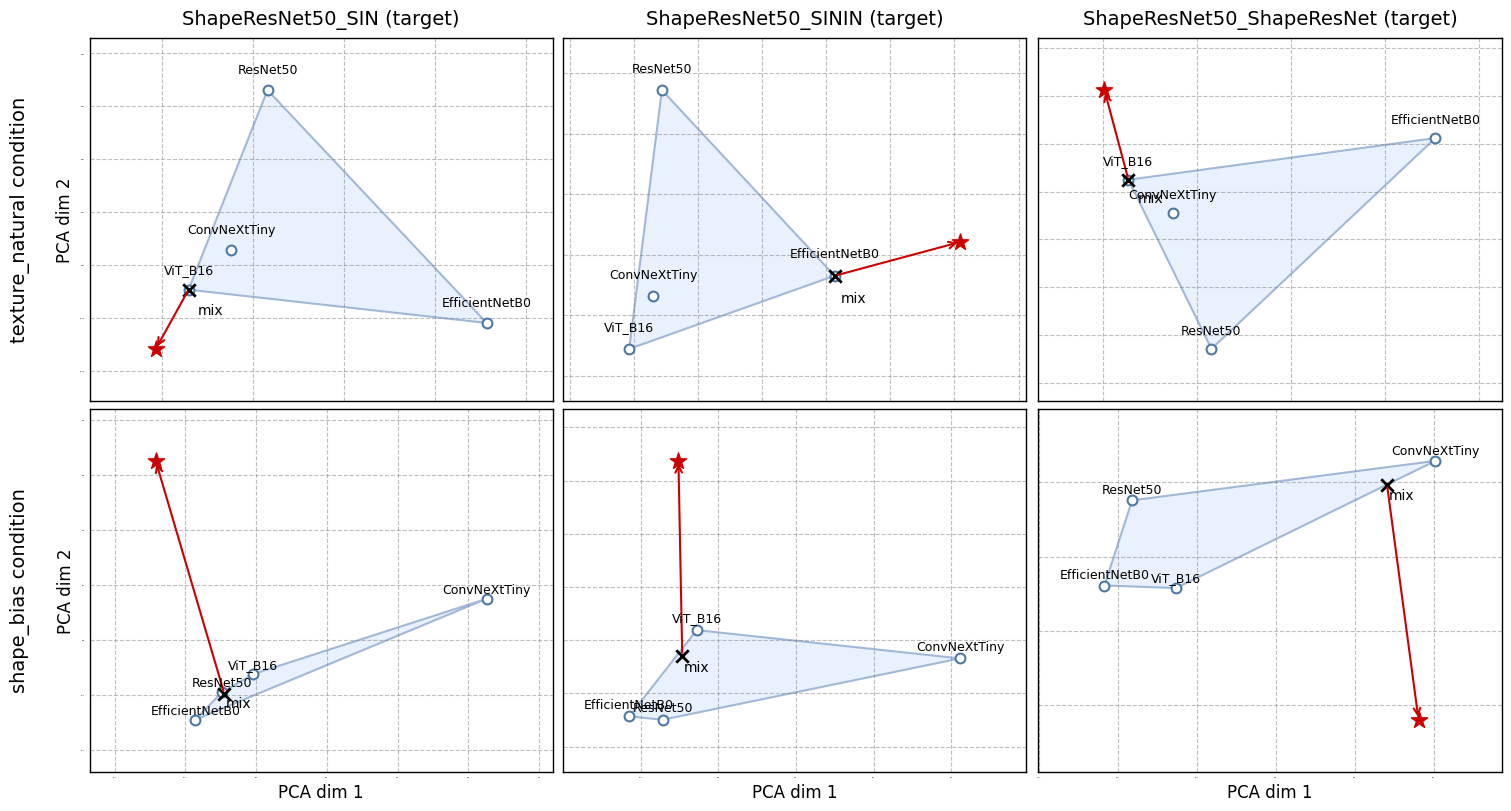

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Configuration
geometry_dir = os.path.join("..", "results", "artifacts", "exp13")
prefix = "exp13_geometry"

shape_targets = [
    "ShapeResNet50_SIN",
    "ShapeResNet50_SININ",
    "ShapeResNet50_ShapeResNet",
]

contexts = ["texture_natural", "shape_bias"]

# Set global font styles to match scientific papers (sans-serif)
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 12,
    "axes.linewidth": 1.0,
    "xtick.major.size": 0,  # Hide tick marks
    "ytick.major.size": 0,
    "xtick.labelsize": 0,   # Hide tick numbers
    "ytick.labelsize": 0,
})

def load_geometry(target_name: str, context: str):
    # Ensure this path logic matches your local setup
    fname = f"{prefix}_{target_name}_{context}.npz"
    path = os.path.join(geometry_dir, fname)
    if not os.path.exists(path):
        # Fallback for testing if file doesn't exist
        print(f"Warning: File not found {path}, returning mock data.")
        return mock_data(target_name) 
    data = np.load(path, allow_pickle=True)
    return data

# Mock data function just in case you run this without files, 
# you can remove this if your files are present.
def mock_data(target_name):
    return {
        "coords": np.random.rand(10, 2),
        "labels": ["ResNet50", "ViT_B16", "ConvNextTiny", "EfficientNetB0"] + ["Peer"]*6,
        "peer_mask": np.array([True]*4 + [False]*6),
        "hull_vertices": [0, 1, 3, 2], # Indices
        "target_idx": 4,
        "mix_idx": 5,
        "explained_variance": [0.8, 0.1],
        "target_name": target_name,
        "l2_dist": 0.0033
    }

# 1. Pre-calculate L2 max for potential scaling (optional)
l2_map = {}
for t in shape_targets:
    for ctx in contexts:
        try:
            d = load_geometry(t, ctx)
            l2_dist_val = float(d["l2_dist"])
            l2_map[(t, ctx)] = l2_dist_val
        except:
            l2_map[(t, ctx)] = 0.0

def format_scientific_latex(value):
    """Converts 0.0033 to 3.3 x 10^-3 string for LaTeX."""
    str_val = "{:.1e}".format(value)
    base, exponent = str_val.split("e")
    return fr"{base} \times 10^{{{int(exponent)}}}"

def plot_geometry_style(ax, data, l2_dist, is_last_col=False):
    coords = data["coords"]
    labels = data["labels"]
    peer_mask = data["peer_mask"]
    hull_vertices = data["hull_vertices"]
    target_idx = int(data["target_idx"])
    mix_idx = int(data["mix_idx"])

    peers_coords = coords[peer_mask]
    peers_labels = labels[peer_mask]
    target_coord = coords[target_idx]
    mix_coord = coords[mix_idx]
    hull_pts = peers_coords[hull_vertices]

    # --- Colors mimicking the reference image ---
    color_hull_fill = "#dae8fc"  # Light Blue
    color_hull_edge = "#6c8ebf"  # Medium Blue
    color_peer_edge = "#4e79a7"  # Standard Blueish
    color_target_red = "#cc0000" # Dark Red
    
    # 1. Draw Convex Hull (Polygon)
    # Ensure the polygon is closed for the visual outline
    poly = Polygon(hull_pts, closed=True, 
                   facecolor=color_hull_fill, 
                   edgecolor=color_hull_edge, 
                   alpha=0.6, linewidth=1.5, zorder=1)
    ax.add_patch(poly)

    # 2. Draw Peer Points (Hollow circles)
    ax.scatter(peers_coords[:, 0], peers_coords[:, 1], 
               facecolors='white', edgecolors=color_peer_edge, 
               s=50, linewidth=1.5, zorder=3)
    
    # Peer Labels
    for name, (x, y) in zip(peers_labels, peers_coords):
        # Simple offset logic to avoid overlap
        ax.text(x, y + 0.0005, name, fontsize=9, ha="center", va="bottom", zorder=5, color="black")

    # 3. Mix Point (Black Cross)
    ax.scatter(mix_coord[0], mix_coord[1], marker="x", s=80, color="black", linewidth=2, zorder=4)
    ax.text(mix_coord[0] + 0.0005, mix_coord[1] - 0.0005, "mix", fontsize=10, va="top", zorder=5)

    # 4. Target Point (Red Star)
    tname = str(data["target_name"])
    ax.scatter(target_coord[0], target_coord[1], marker="*", s=150, color=color_target_red, zorder=5)
    
    # Target Label (Red, next to star)
    # ax.text(target_coord[0], target_coord[1] + 0.001, tname, 
            # fontsize=10, color=color_target_red, ha="center", va="bottom", fontweight='bold', zorder=6)

    # 5. Residual Arrow (Red)
    ax.annotate("", xy=(target_coord[0], target_coord[1]), xytext=(mix_coord[0], mix_coord[1]),
                arrowprops=dict(arrowstyle="->", color=color_target_red, lw=1.5), zorder=4)

    # 6. L2 Distance Annotation
    # Calculate midpoint for text placement
    mid_x = (mix_coord[0] + target_coord[0]) / 2
    mid_y = (mix_coord[1] + target_coord[1]) / 2
    
    # Offset perpendicular to the line slightly (optional, or just place above)
    latex_val = format_scientific_latex(l2_dist)
    text_str = fr"$\|t - \hat{{t}}\|_2 = {latex_val}$"
    
    # Place text slightly above the arrow
    # ax.text(mid_x, mid_y + 0.0015, text_str, fontsize=11, ha="center", zorder=6)

    # 7. Axes styling
    ax.grid(True, linestyle="--", alpha=0.5, color="gray")
    
    # Set labels
    ax.set_xlabel("PCA dim 1", fontsize=12)
    ax.set_ylabel("PCA dim 2", fontsize=12)

    # Force margins to ensure labels don't get cut off
    ax.margins(x=0.2, y=0.2)


# --- Main Plotting Loop ---

fig, axes = plt.subplots(len(contexts), len(shape_targets), figsize=(15, 8), constrained_layout=True)

for row_idx, ctx in enumerate(contexts):
    for col_idx, target_name in enumerate(shape_targets):
        
        ax = axes[row_idx, col_idx]
        data = load_geometry(target_name, ctx)
        l2_d = l2_map.get((target_name, ctx), 0.0)

        # Plot content
        plot_geometry_style(ax, data, l2_d)

        # --- Title Handling (Column Headers) ---
        if row_idx == 0:
            # Clean up title: "ShapeResNet50_SIN (target)"
            clean_title = f"{target_name} (target)"
            ax.set_title(clean_title, fontsize=14, pad=10)

        # --- Row Label Handling (Left Side) ---
        if col_idx == 0:
            # We add a large text label to the left of the axis
            # This mimics the "texture_natural condition" vertical text
            ax.text(-0.15, 0.5, f"{ctx} condition", 
                    transform=ax.transAxes, 
                    fontsize=14, rotation=90, 
                    va='center', ha='center')

# Remove standard y-labels from inner plots to clean up
for ax in axes.flatten():
    ax.label_outer()

# Save
save_path = os.path.join("../results/figures/", "fig13_convex_hull.pdf")
plt.savefig(save_path, format="pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved to: {save_path}")


# plt.tight_layout() # Using constrained_layout=True in subplots instead
plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Saved: ../results/figures/geometry_convex_hull.pdf


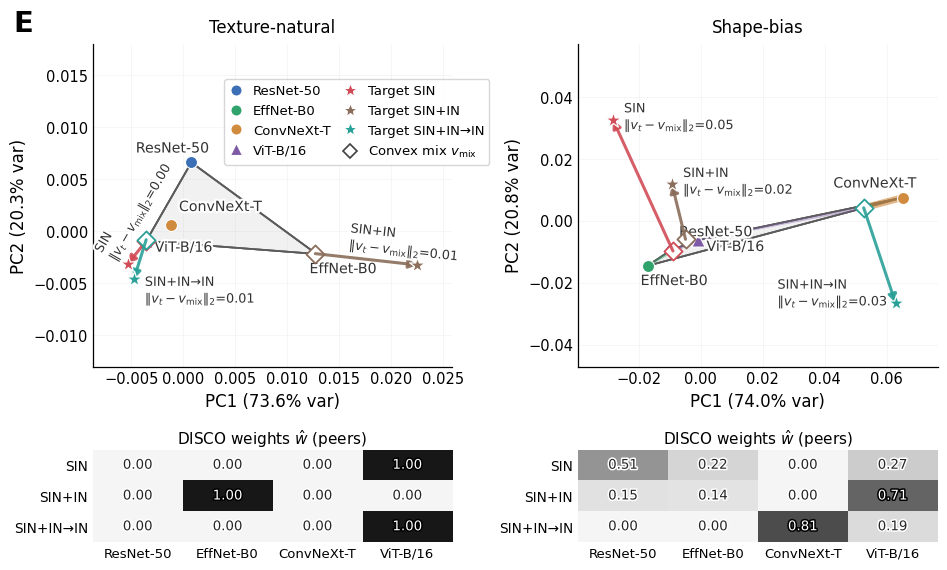

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon
import matplotlib.patheffects as pe

import matplotlib.colors as mcolors

def _truncate_cmap(cmap, minval=0.08, maxval=0.92, n=256):
    """Trim colormap extremes (more print-friendly)."""
    return mcolors.LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )

# -------------------------
# Helpers: loading Exp13 artifacts
# -------------------------
def _find_exp13_npz(artifact_dir: str, prefix: str, target_name: str, context: str) -> str:
    """
    Find the artifact path for a given (target_name, context).

    Expected filename:
      {prefix}_{target_name}_{context}.npz
    """
    pattern = os.path.join(artifact_dir, f"{prefix}_{target_name}_{context}.npz")
    hits = glob.glob(pattern)
    if len(hits) == 0:
        raise FileNotFoundError(f"Missing artifact: {pattern}")
    return hits[0]


def _load_exp13_record(path: str) -> dict:
    """
    Load one Exp13 npz record and return a plain dict.
    """
    z = np.load(path, allow_pickle=True)
    rec = {k: z[k] for k in z.files}
    # Normalize some fields to python strings/lists
    rec["labels"] = [str(x) for x in rec["labels"].tolist()]
    rec["peers"] = [str(x) for x in rec["peers"].tolist()]
    rec["context"] = str(rec["context"])
    rec["target_name"] = str(rec["target_name"])
    rec["hull_vertices"] = rec["hull_vertices"].astype(int)
    rec["target_idx"] = int(rec["target_idx"])
    rec["mix_idx"] = int(rec["mix_idx"])
    rec["w_hat"] = rec["w_hat"].astype(float).flatten()
    rec["coords"] = rec["coords"].astype(float)
    rec["explained_variance"] = rec["explained_variance"].astype(float).flatten()
    rec["l2_dist"] = float(rec["l2_dist"])
    return rec

def annotate_offset(ax, xy, text, dx=6, dy=6, fontsize=10.5, color="0.20",
                    rotation=0, **kwargs):
    """
    Place text near a point using screen-space offsets (points), not data-space offsets.
    Supports text rotation via `rotation` (degrees).
    """
    return ax.annotate(
        text,
        xy=xy,
        xytext=(dx, dy),
        textcoords="offset points",
        ha=kwargs.pop("ha", "left"),
        va=kwargs.pop("va", "bottom"),
        fontsize=fontsize,
        color=color,
        rotation=rotation,
        **kwargs
    )

# -------------------------
# Helpers: Procrustes alignment (similarity transform)
# -------------------------
def _similarity_align(source_pts: np.ndarray, ref_pts: np.ndarray):
    """
    Similarity transform (scale * rotation + translation) mapping source_pts -> ref_pts.
    Always returns a function that maps an array of shape (n,2) -> (n,2).
    """
    X = np.asarray(source_pts, dtype=float)
    Y = np.asarray(ref_pts, dtype=float)

    if X.ndim != 2 or Y.ndim != 2 or X.shape[1] != 2 or Y.shape[1] != 2:
        raise ValueError("source_pts and ref_pts must be (n,2) arrays.")

    mx = X.mean(axis=0)
    my = Y.mean(axis=0)
    X0 = X - mx
    Y0 = Y - my

    nx = np.linalg.norm(X0)
    ny = np.linalg.norm(Y0)
    if nx < 1e-12 or ny < 1e-12:
        def f(P):
            P = np.asarray(P, dtype=float)
            if P.ndim == 1:
                P = P[None, :]
            return (P - mx) + my
        return f

    X1 = X0 / nx
    Y1 = Y0 / ny

    M = X1.T @ Y1
    U, _, Vt = np.linalg.svd(M)
    R = U @ Vt

    # Similarity scale
    s = ny / nx

    # Translation so that s*(mx R) + t = my
    t = my - s * (mx @ R)

    def f(P):
        P = np.asarray(P, dtype=float)
        if P.ndim == 1:
            P = P[None, :]
        return s * (P @ R) + t

    return f

# -------------------------
# Main plotting function
# -------------------------
def plot_fig_exp13_convex_hull_geometry(
    artifact_dir: str = "../results/artifacts/exp13",
    prefix: str = "exp13_geometry",
    save_path: str = None,
    weight_ray_threshold: float = 0.15,
):
    """
    High-density geometry figure for Exp13.

    Layout:
      Top row: 2 large panels (Natural vs Shape-bias), each overlays 3 ecosystems (A/B/C)
               after aligning PCA coordinates by matching the 4 peer points.
      Bottom row: 2 weight heatmaps (3 variants x 4 peers) for the corresponding context.

    Visual semantics:
      - Peer points define a convex hull (filled polygon).
      - For each target variant: star = target, diamond = convex peer mix, arrow = distance-to-hull direction.
      - Optional "weight rays": from mix to peers for weights above threshold.
      - Heatmap shows w_hat for each variant and context.
    """

    # Target names (Exp13)
    targets = [
        "ShapeResNet50_SIN",
        "ShapeResNet50_SININ",
        "ShapeResNet50_ShapeResNet",
    ]
    target_pretty = {
        "ShapeResNet50_SIN": "SIN",
        "ShapeResNet50_SININ": "SIN+IN",
        "ShapeResNet50_ShapeResNet": "SIN+IN→IN",
    }

    contexts = ["texture_natural", "shape_bias"]
    context_pretty = {
        "texture_natural": "Texture-natural",
        "shape_bias": "Shape-bias",
    }

    # Consistent peer ordering (Exp13 uses these 4 as peers)
    peers = ["ResNet50", "EfficientNetB0", "ConvNeXtTiny", "ViT_B16"]
    peer_pretty = {
        "ResNet50": "ResNet-50",
        "EfficientNetB0": "EffNet-B0",
        "ConvNeXtTiny": "ConvNeXt-T",
        "ViT_B16": "ViT-B/16",
    }

    # Colors (muted, Nature-like; consistent across contexts)
    # PEER_COLORS = {
    #     "ResNet50": "#4E79A7",         # muted blue
    #     "EfficientNetB0": "#59A14F",   # muted green
    #     "ConvNeXtTiny": "#F28E2B",     # muted orange
    #     "ViT_B16": "#B07AA1",          # muted purple
    # }

    PEER_COLORS = {
        "ResNet50":        "#3B6FB6",  # deep muted blue
        "EfficientNetB0":  "#2FA36B",  # muted green
        "ConvNeXtTiny":    "#D08B3E",  # muted ochre (less neon than orange)
        "ViT_B16":         "#7E5AA6",  # muted purple
    }

    # One color per target variant (so you can track the 3 arrows easily)
    VARIANT_COLORS = {
        "ShapeResNet50_SIN":        "#D24C57",  # muted crimson
        "ShapeResNet50_SININ":      "#8A6D5A",  # warm brown
        "ShapeResNet50_ShapeResNet":"#2AA198",  # teal (cool, modern)
    }

    # Matplotlib style
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 12,
        "axes.labelsize": 12,
        "xtick.labelsize": 10.5,
        "ytick.labelsize": 10.5,
        "axes.linewidth": 0.9,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

    # Figure layout (top: big geometry; bottom: skinny weight heatmaps)
    fig = plt.figure(figsize=(9.6, 5.6))
    gs = GridSpec(
        2, 2,
        figure=fig,
        height_ratios=[4.2, 1.2],
        width_ratios=[1.0, 1.0],
        hspace=0.4,
        wspace=0.35,
    )

    ax_geo = {
        contexts[0]: fig.add_subplot(gs[0, 0]),
        contexts[1]: fig.add_subplot(gs[0, 1]),
    }
    ax_w = {
        contexts[0]: fig.add_subplot(gs[1, 0]),
        contexts[1]: fig.add_subplot(gs[1, 1]),
    }

    # Load all records first
    rec = {ctx: {} for ctx in contexts}
    for ctx in contexts:
        for t in targets:
            path = _find_exp13_npz(artifact_dir, prefix, t, ctx)
            rec[ctx][t] = _load_exp13_record(path)

    # Plot each context panel
    for ctx in contexts:
        ax = ax_geo[ctx]
        ax.grid(True, linewidth=0.6, alpha=0.12)
        ax.set_axisbelow(True)

        # Use SIN as the reference coordinate system in this context
        ref = rec[ctx]["ShapeResNet50_SIN"]
        ref_coords = ref["coords"]
        ref_peer_coords = ref_coords[:len(peers), :]

        # Build hull polygon from ref peers (use saved hull vertex order)
        hull_idx = ref["hull_vertices"].tolist()
        hull_poly = ref_peer_coords[hull_idx, :]
        ax.add_patch(Polygon(
            hull_poly,
            closed=True,
            facecolor="0.92",
            edgecolor="0.55",
            linewidth=1.2,
            alpha=0.85,
            zorder=0,
        ))
        # Outline hull explicitly (close the loop)
        hull_loop = np.vstack([hull_poly, hull_poly[:1]])
        ax.plot(hull_loop[:, 0], hull_loop[:, 1], color="0.40", lw=1.3, alpha=0.9, zorder=1)
        peer_offsets = {
            "ResNet50": (6, 8),
            "EfficientNetB0": (-5, -16),
            "ConvNeXtTiny": (6, 8),
            "ViT_B16": (6, -10),
        }
        # Plot peers (once, from reference)
        for i, p in enumerate(peers):
            x, y = ref_peer_coords[i]
            mk = "^" if p == "ViT_B16" else "o"
            ax.scatter(
                [x], [y],
                s=90 if p == "ViT_B16" else 75,
                marker=mk,
                color=PEER_COLORS[p],
                edgecolor="white",
                linewidth=0.8,
                zorder=3,
            )
            dx, dy = peer_offsets.get(p, (6, 6))
            if p == "ConvNeXtTiny" and ctx == "shape_bias":
                dx, dy = -50, 5
            elif p == "ResNet50" and ctx == "texture_natural":
                dx, dy, rotate = -40, 5, 0
            annotate_offset(
                ax,
                (x, y),
                peer_pretty[p],
                dx=dx, dy=dy,                     
                fontsize=10.2,
                color="0.20",
                path_effects=[pe.withStroke(linewidth=3, foreground="white")],
                zorder=4,
            )

        # Overlay 3 variants after alignment
        all_pts = [ref_peer_coords]  # for axis limits
        for t in targets:
            r = rec[ctx][t]
            coords = r["coords"]
            peer_coords = coords[:len(peers), :]
            target_xy = coords[r["target_idx"], :]
            mix_xy = coords[r["mix_idx"], :]
            w_hat = r["w_hat"]
            d_hi = r["l2_dist"]

            # Align this ecosystem to the reference (match peer points)
            f_align = _similarity_align(peer_coords, ref_peer_coords)
            target_xy_a = f_align(target_xy)[0]
            mix_xy_a = f_align(mix_xy)[0]
            peer_xy_a = f_align(peer_coords)   # already (4,2)

            all_pts.append(np.vstack([target_xy_a, mix_xy_a, peer_xy_a]))

            c_var = VARIANT_COLORS[t]

            # Mix point (convex projection inside hull)
            ax.scatter(
                [mix_xy_a[0]], [mix_xy_a[1]],
                s=85, marker="D",
                facecolor="white",
                edgecolor=c_var,
                linewidth=1.3,
                zorder=5,
            )

            # Target point
            ax.scatter(
                [target_xy_a[0]], [target_xy_a[1]],
                s=140, marker="*",
                color=c_var,
                edgecolor="white",
                linewidth=0.9,
                zorder=6,
            )

            # Arrow: "distance-to-hull" direction (geometry of PIER)
            ax.annotate(
                "",
                xy=(target_xy_a[0], target_xy_a[1]),
                xytext=(mix_xy_a[0], mix_xy_a[1]),
                arrowprops=dict(
                    arrowstyle="-|>",
                    lw=2.2,
                    color=c_var,
                    alpha=0.90,
                    shrinkA=0,
                    shrinkB=0,
                ),
                zorder=5,
            )

            # Optional: weight rays (only draw strong contributors to avoid clutter)
            for j, p in enumerate(peers):
                w = float(w_hat[j])
                if w < weight_ray_threshold:
                    continue
                px, py = ref_peer_coords[j]  # use reference peer location
                lw = 0.8 + 5.0 * w
                ax.plot(
                    [mix_xy_a[0], px],
                    [mix_xy_a[1], py],
                    color=PEER_COLORS[p],
                    lw=lw,
                    alpha=0.22 + 0.40 * min(1.0, w / 0.5),
                    zorder=2,
                )

            # Tiny label near target (variant name + high-D distance)
            if t == "ShapeResNet50_SININ" and ctx == "texture_natural":
                dx, dy, rotate = -50, 0, -6
            elif t == "ShapeResNet50_ShapeResNet" and ctx == "texture_natural":
                dx, dy, rotate = 8, -20, 0
            elif t == "ShapeResNet50_SIN" and ctx == "texture_natural":
                dx, dy, rotate = -25, 0, 60
            elif t == "ShapeResNet50_ShapeResNet" and ctx == "shape_bias":
                dx, dy, rotate = -85, -5, 0
            else:
                dx, dy, rotate = 8, -10, 0
            annotate_offset(
                ax,
                (target_xy_a[0], target_xy_a[1]),
                f"{target_pretty[t]}\n" + r"$\|v_t - v_{\mathrm{mix}}\|_2$" + f"={d_hi:.2f}",
                dx=dx, dy=dy,  
                rotation=rotate,                
                fontsize=9.2,
                color="0.20",
                path_effects=[pe.withStroke(linewidth=3, foreground="white")],
                zorder=7,
            )
            
        # Axis labels include explained variance (from ref PCA)
        ev = ref["explained_variance"]
        ax.set_xlabel(f"PC1 ({100*ev[0]:.1f}% var)")
        ax.set_ylabel(f"PC2 ({100*ev[1]:.1f}% var)")
        ax.set_title(context_pretty[ctx], fontsize=12, pad=8)

        # Nice limits with padding
        P = np.vstack(all_pts)
        xmin, ymin = P.min(axis=0)
        xmax, ymax = P.max(axis=0)
        padx = 0.12 * (xmax - xmin + 1e-12)
        pady = 0.12 * (ymax - ymin + 1e-12)
        ax.set_xlim(xmin - padx, xmax + padx)
        ax.set_aspect("equal", adjustable="datalim")
        if ctx == "texture_natural":
            ax.set_ylim(-0.010, 0.015)
        else:
            ax.set_ylim(-0.03, 0.04)


        # # Clean spines
        # for sp in ax.spines.values():
        #     sp.set_visible(False)
        
        ax.add_patch(Polygon(hull_poly, closed=True,
                            facecolor="0.95", edgecolor="0.45",
                            linewidth=1.2, alpha=0.85, zorder=0))
        ax.plot(hull_loop[:,0], hull_loop[:,1], color="0.35", lw=1.2, alpha=0.9, zorder=1)


    # -------------------------
    # Weight heatmaps (bottom row)
    # -------------------------
    for ctx in contexts:
        ax = ax_w[ctx]
        ax.grid(False)

        W = np.zeros((len(targets), len(peers)), dtype=float)
        for i, t in enumerate(targets):
            W[i, :] = rec[ctx][t]["w_hat"]

        # Better colormap (slightly truncated Greys to avoid extreme blacks/whites)
        CMAP = _truncate_cmap(plt.get_cmap("Greys"), 0.08, 0.92)

        im = ax.imshow(W, aspect="auto", cmap=CMAP, vmin=0.0, vmax=1.0)

        # Subtle cell borders (Nature-like)
        # Ticks/labels
        ax.set_xticks(np.arange(len(peers)))
        ax.set_xticklabels([peer_pretty[p] for p in peers], rotation=0, fontsize=9.5)
        ax.set_yticks(np.arange(len(targets)))
        ax.set_yticklabels([target_pretty[t] for t in targets], fontsize=9.8)
        ax.set_title("DISCO weights $\\hat{w}$ (peers)", fontsize=11, pad=4)

        W_show = W.copy()
        W_show[np.isclose(W_show, 0.0, atol=5e-7)] = 0.0   # kill "-0.00"
        W_show = np.clip(W_show, 0.0, 1.0)

        # Annotate with contrast-aware text color + stroke
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                v = float(W_show[i, j])
                rgba = im.cmap(im.norm(v))
                lum = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
                txt_color = "white" if lum < 0.55 else "0.15"

                ax.text(
                    j, i, f"{v:.2f}",
                    ha="center", va="center",
                    fontsize=9.6,
                    color=txt_color,
                    path_effects=[pe.withStroke(linewidth=2.2, foreground="black" if txt_color=="white" else "white")],
                    zorder=5
                )


        # Minimal frame
        for sp in ax.spines.values():
            sp.set_visible(False)

    # Figure-level legend (peers + variants)
    handles = []
    for p in peers:
        mk = "^" if p == "ViT_B16" else "o"
        handles.append(plt.Line2D(
            [0], [0], marker=mk, linestyle="None",
            markersize=8,
            markerfacecolor=PEER_COLORS[p],
            markeredgecolor="white",
            markeredgewidth=0.8,
            label=peer_pretty[p],
        ))
    for t in targets:
        handles.append(plt.Line2D(
            [0], [0], marker="*", linestyle="None",
            markersize=10,
            markerfacecolor=VARIANT_COLORS[t],
            markeredgecolor="white",
            markeredgewidth=0.8,
            label=f"Target {target_pretty[t]}",
        ))
    handles.append(plt.Line2D(
        [0], [0], marker="D", linestyle="None",
        markersize=7,
        markerfacecolor="white",
        markeredgecolor="0.25",
        markeredgewidth=1.2,
        label=r"Convex mix $v_{\mathrm{mix}}$",
    ))

    fig.legend(
        handles=handles,
        frameon=True,
        ncol=2,
        fontsize=9.5,
        loc="right",
        columnspacing=1.0,
        handlelength=1.0,
        bbox_to_anchor=(0.52, 0.80),
    )

    # Panel label (if you want it)
    ax_geo[contexts[0]].text(-0.22, 1.02, "E", transform=ax_geo[contexts[0]].transAxes,
                            fontsize=21, fontweight="bold", va="bottom")

    fig.subplots_adjust(left=0.10, right=0.98, top=0.94, bottom=0.05)

    if save_path is not None:
        fig.savefig(save_path)
        print(f"Saved: {save_path}")

    plt.show()
    return fig


# Example usage:
plot_fig_exp13_convex_hull_geometry(
    artifact_dir="../results/artifacts/exp13",
    prefix="exp13_geometry",
    save_path=os.path.join("../results/figures", "geometry_convex_hull.pdf"),
    weight_ray_threshold=0.15,
);
